In [2]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn 
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, LabelEncoder
from scipy import stats
from sklearn.metrics import accuracy_score

import data_functions as fn
import model as md

In [5]:
# Read in the cleaned data from the previous notebook
team_data = pd.read_csv('BasketballData.csv').drop('Unnamed: 0', axis=1)
team_data = team_data[team_data.TeamID.notnull()]
# Read in the file including data from 2 years prior
team_data_new = pd.read_csv('NCAA_data.csv').drop('Unnamed: 0', axis=1)
team_data_new = team_data_new[team_data_new.TeamID.notnull()]

### First I will look at the correlation between the features by constructing a heatmap

In [6]:
plot_data = team_data.drop(['DayNum','TeamID','Opp_TeamID','Win','Season'], axis=1)

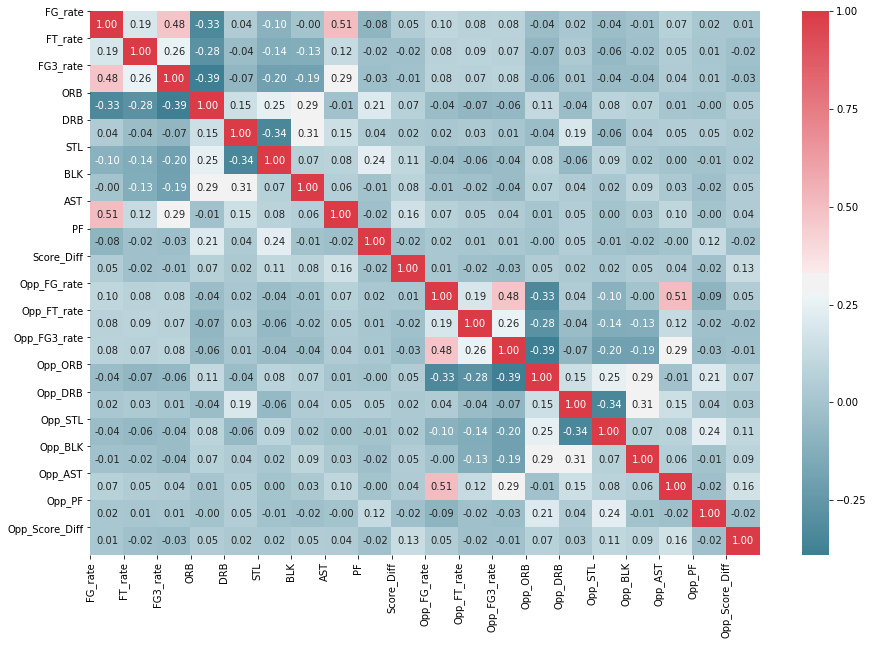

<Figure size 432x288 with 0 Axes>

In [7]:
fn.get_corr_heat_map(plot_data, False)
plt.savefig('CorrelationHeatMap_labeled.jpg')
plt.show()

### None of the features appear to be strongly correlated with each other. However, there appears to be a slight correlation between field goal rate and 3 point rate, and field goal rate and assists.

In [9]:
# Read in the tournament data
tour_data = pd.read_csv('DataFiles/NCAATourneyCompactResults.csv')
tour_data = tour_data[tour_data.Season>2007]

In [12]:
# Fill null values with the column mean
data = team_data_new.apply(lambda x: x.fillna(x.mean()), axis=0)
data.shape

(93163, 45)

In [499]:
# Create a column indicating whether the team was in the tournament the previous season
prev_trn = []

for i in data.index:
    year = data.Season[i]
    trn_df = tour_data[tour_data.Season==year-1]
    
    trn_list = [trn_df.WTeamID[k] for k in trn_df.index] + [trn_df.LTeamID[k] for k in trn_df.index]
    
    if data.TeamID[i] in trn_list:
        prev_trn.append(1)
    elif data.TeamID[i] not in trn_list:
        prev_trn.append(0)

data['Prev_Tourn'] = prev_trn

# Add a column indicating whether the team was in the tournament 2 years prior
trn_2yr = []

for i in data.index:
    year = data.Season[i]
    trn2_df = tour_data[tour_data.Season==year-2]
    
    trn2_list = [trn2_df.WTeamID[k] for k in trn2_df.index] + [trn2_df.LTeamID[k] for k in trn2_df.index]
    
    if data.TeamID[i] in trn2_list:
        trn_2yr.append(1)
    elif data.TeamID[i] not in trn2_list:
        trn_2yr.append(0)
        
data['Tourn_2yr'] = trn_2yr

In [504]:
# Read in the team rankings data
rankings = pd.read_csv('TeamRankings.csv').drop('Unnamed: 0', axis=1)
rankings.head(3)

,2018,School,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004,2003,2002,2001,2000
0,1,Villanova,5,1,5,9,51,71,23,17,14,47,19,6,13,50,59,50,75,72
1,2,Duke,9,12,2,6,4,12,2,1,6,5,11,2,3,1,6,1,1,2
2,3,Purdue,15,9,34,71,64,24,8,13,18,31,27,145,87,51,22,67,28,24


In [505]:
# Read in the file with the team names and IDs so that the correct IDs can be added to the rankings data
team_id_pairs = pd.read_csv('Team_id_pairs.csv').drop('Unnamed: 0', axis=1)

team_id_dict = {}

for i in team_id_pairs.index:
    name = team_id_pairs.TeamName[i]
    team_id = team_id_pairs.TeamID[i]
    team_id_dict[name] = team_id

In [506]:
# Create a column with the team IDs in the rankings data
t_id_list = []

for i in rankings.index:
    name = rankings.School[i]
    if name in team_id_dict:
        team_id = int(team_id_dict[name])
        t_id_list.append(team_id)
    elif name not in team_id_dict:
        t_id_list.append(0)
    
rankings['TeamID'] = t_id_list

rankings.head(3)

,2018,School,2017,2016,2015,2014,2013,2012,2011,2010,...,2008,2007,2006,2005,2004,2003,2002,2001,2000,TeamID
0,1,Villanova,5,1,5,9,51,71,23,17,...,47,19,6,13,50,59,50,75,72,1437
1,2,Duke,9,12,2,6,4,12,2,1,...,5,11,2,3,1,6,1,1,2,1181
2,3,Purdue,15,9,34,71,64,24,8,13,...,31,27,145,87,51,22,67,28,24,1345


In [507]:
# Create a column in the main dataframe with the team's ranking from the two previous years
prev_rank = []
rank_2yrs = [] # Added

for i in data.index:
    prev_year = str(data.Season[i]-1)
    two_yr = str(data.Season[i]-2) # Added 
    team = data.TeamID[i]
    rank_year = list(rankings.TeamID)
    
    if team in rank_year:
        k = rankings[rankings.TeamID==team].index[0]
        rank = rankings[prev_year][k]
        rank_2 = rankings[two_yr][k] # Added
        prev_rank.append(int(rank))
        rank_2yrs.append(int(rank_2)) # Added
    elif team not in rank_year:
        prev_rank.append(np.nan)
        rank_2yrs.append(np.nan) # Added
        
data['Prev_Rank'] = prev_rank
data['Rank_2yrs'] = rank_2yrs

In [508]:
# Export the data to a csv file
data.to_csv('BasketBallData_new.csv')

### Now I will construct a few scatterplots to look at the correlation between some of the features

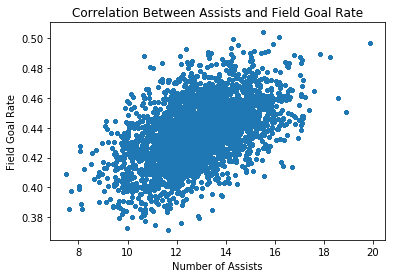

In [410]:
# Plot the number of assists vs field goal rate
fg = data.FG_rate
ast = data.AST
plt.plot(ast, fg, marker='.', linestyle='none')
plt.xlabel('Number of Assists')
plt.ylabel('Field Goal Rate')
plt.title('Correlation Between Assists and Field Goal Rate')
plt.savefig('Assists_FieldGoals_plot.png')
plt.show()

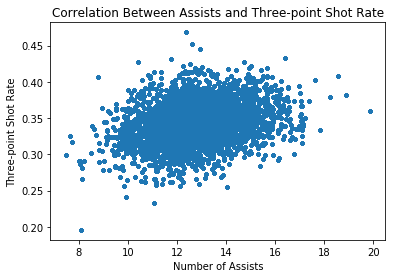

In [411]:
# Plot the number of assists vs. three point rate
fg3 = data.FG3_rate
ast = data.AST
plt.plot(ast, fg3, marker='.', linestyle='none')
plt.xlabel('Number of Assists')
plt.ylabel('Three-point Shot Rate')
plt.title('Correlation Between Assists and Three-point Shot Rate')
plt.savefig('Assists_3pt_plot.png')
plt.show()

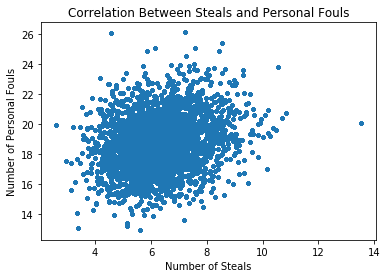

In [412]:
# Plot the number of steals vs. number of personal fouls
stl = data.STL
pf = data.PF
plt.plot(stl, pf, marker='.', linestyle='none')
plt.xlabel('Number of Steals')
plt.ylabel('Number of Personal Fouls')
plt.title('Correlation Between Steals and Personal Fouls')
plt.savefig('Steals_Fouls_plot.png')
plt.show()

### Create boxplots for the field goal rates for each season to see if it has changed over time

In [413]:
fg_rates = []
for s in data.Season.unique():
    sr = list(data[data.Season==s].FG_rate)
    fg_rates.append(sr)

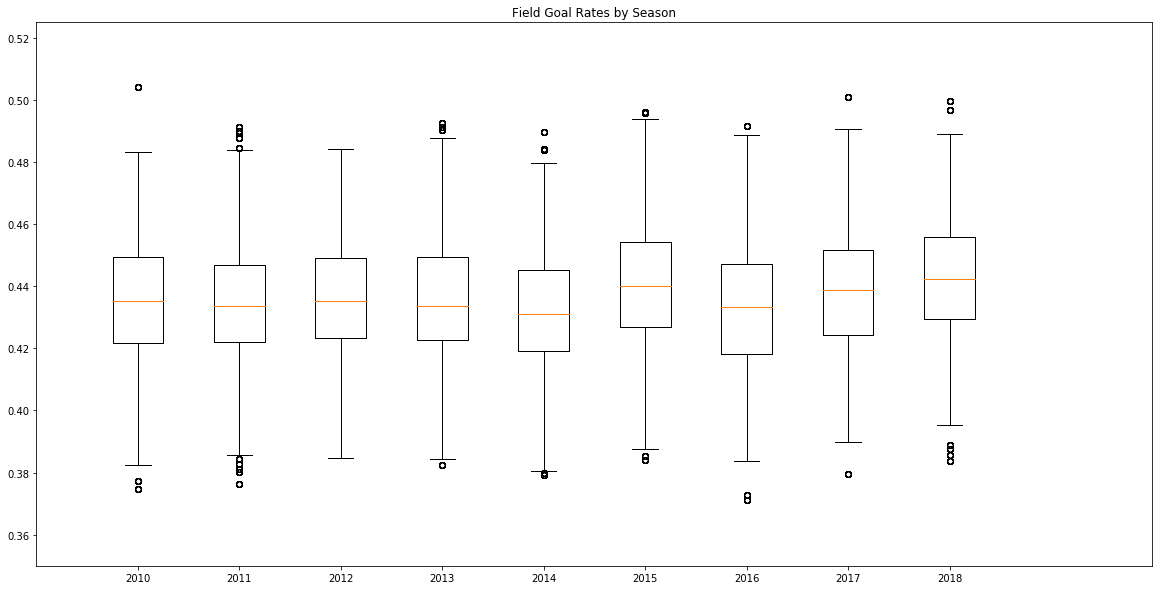

In [414]:
fig1, ax1 = plt.subplots(figsize=(20, 10))
ax1.set_title('Field Goal Rates by Season')
_= plt.boxplot(fg_rates, labels = data.Season.unique())
plt.axis([0, 11, 0.35, 0.525])
plt.show()

### There does not appear to be any significant change in the field goal rates over the past 10 years

### Next I will split the data by wins and losses, and compare some of the features

In [415]:
df = pd.read_csv('BasketBallData_2.csv').drop('Unnamed: 0', axis=1)

w_df = df[df.Win==1].drop('Win', axis=1)
n_df = df[df.Win==0].drop('Win', axis=1)

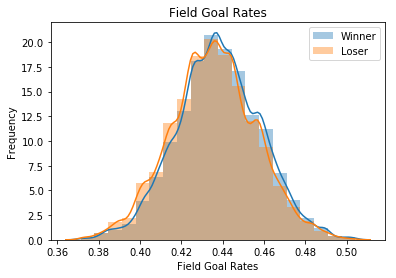

In [424]:
sns.distplot(w_df.FG_rate, bins=20, label='Winner')
sns.distplot(n_df.FG_rate, bins=20, label='Loser')
plt.title('Field Goal Rates')
plt.xlabel('Field Goal Rates')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('FieldGoalRates_hist.png')
plt.show()

### Conduct a hypothesis test for the difference between the features for winners and losers. 

In [417]:
fn.test_for_difference(w_df, n_df, 'two-sided')

The p-value for the difference between  Season is:  0.8638022145217455
The p-value for the difference between  DayNum is:  0.301733929651799
The p-value for the difference between  TeamID is:  1.0940954293605561e-21
The p-value for the difference between  Opp_TeamID is:  2.1730606160780826e-23
The p-value for the difference between  FG_rate is:  1.1690992187359074e-90
The p-value for the difference between  FT_rate is:  2.1576137072197745e-22
The p-value for the difference between  FG3_rate is:  0.040847905191971234
The p-value for the difference between  ORB is:  9.917218927705898e-60
The p-value for the difference between  DRB is:  4.869128034197389e-29
The p-value for the difference between  STL is:  0.010894369429761165
The p-value for the difference between  BLK is:  1.024531353973396e-115
The p-value for the difference between  AST is:  4.265029450411848e-113
The p-value for the difference between  PF is:  2.889326685407225e-09
The p-value for the difference between  Score_Diff i

### We can see that most of the features are significant

In [14]:
# Read in the data file to be used to build the model
model_df = pd.read_csv('BasketBallData_new.csv').drop('Unnamed: 0', axis=1)

In [34]:
# Use lightgbm to fit a model
import lightgbm as lgb
#model_data = df.drop(['Season', 'DayNum', 'TeamID', 'Opp_TeamID'], axis=1)
model_data = model_df#.drop(['TeamID', 'Opp_TeamID'], axis=1)

X = model_data.drop('Win', axis=1)
y = model_data.Win
# split into test and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12)

lgb_train = lgb.Dataset(X_train, label=y_train, 
                        categorical_feature=['Season','Prev_Tourn','Tourn_2yr','TeamID','Opp_TeamID'],
                        free_raw_data=False)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'binary_logloss',
        'num_leaves': 50, #10
        'max_depth': 15,   #6
        'learning_rate': 0.1
                }

model = lgb.train(params, lgb_train, 200)

/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


In [35]:
y_pred = model.predict(X_test)
# Convert the probabilities to binary values
yp = np.array(y_pred)
yp = np.where(yp > 0.5, 1, 0)

# Compute the accuracy on the test data
score = accuracy_score(y_test, yp)
print('The accuracy on the test data is ', round(100*score, 2), '%')

The accuracy on the test data is  68.61 %


## Tune the hyperparameters

In [82]:
# Tune hyperparameters
from sklearn.model_selection import RandomizedSearchCV

# Use a range of values for the parameters to test
test_params = {
        'num_leaves': [20, 40, 60, 80, 100, 120, 140, 150, 160],
        'n_estimators': [45, 50, 60, 80, 100, 110, 120],
        'colsample_bytree': [0.55, 0.58, 0.6, 0.62, 0.65, 0.68],
        'subsample': [0.65, 0.7, 0.75, 0.8],
        'learning_rate': [0.003, 0.004, 0.005, 0.006, 0.007, 0.0075, 0.008, 0.01],
        'reg_alpha': [0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08],
        'reg_lambda': [0.06, 0.07, 0.08, 0.1, 0.12, 0.15, 0.16, 0.18]
                }
clf = lgb.LGBMClassifier(boosting_type='gbdt',
                        objective='binary', 
                        metric = 'binary_logloss', 
                        random_state = 24)

# Use a randomized search to find the best values for the parameters
randomSearchModel=RandomizedSearchCV(estimator=clf, param_distributions=test_params,
                                               n_iter=1,
                                               cv=8,
                                               refit=True,
                                               verbose=0,
                                               n_jobs=1,
                                               pre_dispatch=1)

randomSearchModel.fit(X_train, y_train)

RandomizedSearchCV(cv=8, error_score='raise-deprecating',
          estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        metric='binary_logloss', min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=31, objective='binary', random_state=24,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0),
          fit_params=None, iid='warn', n_iter=1, n_jobs=1,
          param_distributions={'num_leaves': [20, 40, 60, 80, 100, 120, 140, 150, 160], 'n_estimators': [45, 50, 60, 80, 100, 110, 120], 'colsample_bytree': [0.55, 0.58, 0.6, 0.62, 0.65, 0.68], 'subsample': [0.65, 0.7, 0.75, 0.8], 'learning_rate': [0.003, 0.004, 0.005, 0.006, 0.007, 0.0075, 0.008, 0.01], 'reg_alpha': [0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08], 'reg_lambda': [0.06, 0.07, 

In [83]:
params2 = randomSearchModel.best_params_
params2

{'subsample': 0.7,
 'reg_lambda': 0.12,
 'reg_alpha': 0.08,
 'num_leaves': 80,
 'n_estimators': 100,
 'learning_rate': 0.007,
 'colsample_bytree': 0.65}

In [84]:
model2 = lgb.train(params2, lgb_train, 5000)

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:116: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


In [85]:
y_pred2 = model2.predict(X_test)

yp2 = np.array(y_pred2)
yp2 = np.where(yp2 > 0.5, 1, 0)

# Compute the accuracy on the test data
score = accuracy_score(y_test, yp2)
print('The accuracy on the test data is ', round(100*score, 2), '%')

The accuracy on the test data is  68.3 %


In [86]:
y_hat = np.array(y_pred2)

vals = [0.48, 0.49, 0.495, 0.496, 0.5, 0.505, 0.51, 0.515, 0.52, 0.525, 0.53, 0.535, 0.54]

for v in vals:
    y = np.where(y_hat >= v, 1, 0)
    print('Using ', v, ' the score is: ', round(100*accuracy_score(y_test, y), 2), '%')

Using  0.48  the score is:  67.52 %
Using  0.49  the score is:  67.97 %
Using  0.495  the score is:  68.13 %
Using  0.496  the score is:  68.2 %
Using  0.5  the score is:  68.3 %
Using  0.505  the score is:  68.38 %
Using  0.51  the score is:  68.52 %
Using  0.515  the score is:  68.44 %
Using  0.52  the score is:  68.34 %
Using  0.525  the score is:  68.1 %
Using  0.53  the score is:  67.76 %
Using  0.535  the score is:  67.51 %
Using  0.54  the score is:  67.26 %


In [90]:
y_pred2 = model2.predict(X_train)

# Convert the probabilities to binary values
yp3 = np.array(y_pred2)
yp3 = np.where(yp3 >= 0.5, 1, 0)

# Compute the accuracy on the training data
score_train = accuracy_score(y_train, yp3)
print('The accuracy on the training data is ', round(100*score_train, 2), '%')

The accuracy on the training data is  72.29 %


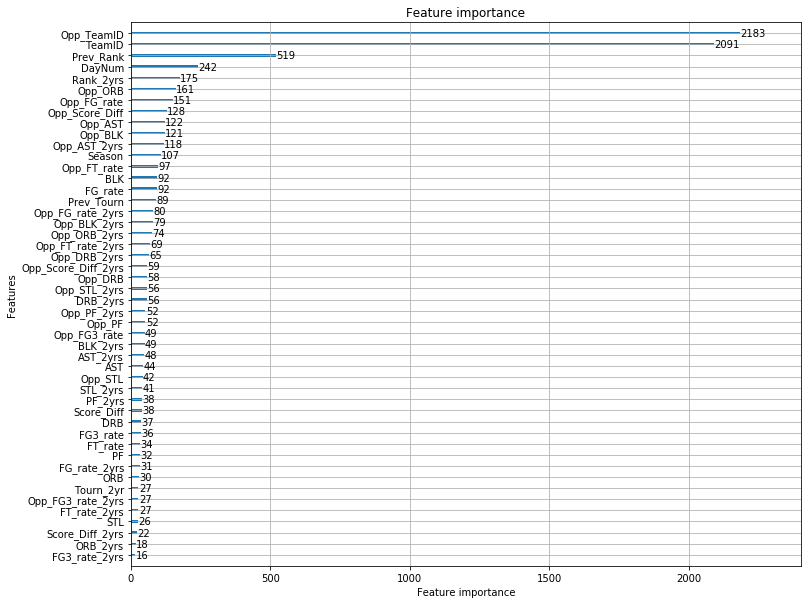

In [91]:
# Plot the feature importanct
_=lgb.plot_importance(model2, figsize=(12, 10))
plt.show()